<a href="https://colab.research.google.com/github/sophieqli/R1-Reasoning/blob/main/LLM_finetuning_with_HugginFace_Peft_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM finetuning with HuggingFace Peft Model


In [ ]:
#!pip install transformers
#!pip install datasets
#!pip uninstall -y torch torchvision torchaudio
#!pip install torch==2.2.0+cu118 torchvision==0.17.0+cu118 torchaudio==2.2.0 --extra-index-url https://download.pytorch.org/whl/cu118
!pip install trl

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from trl import SFTConfig, SFTTrainer
from peft import LoraConfig, TaskType

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA available: True
GPU name: Tesla T4


In [ ]:
# load smolLM from hugging face (only ~100M params)
# note you will want to set your colab runtime to use the gpu
MODEL_NAME = "HuggingFaceTB/SmolLM2-135M"
device = "cuda" if torch.cuda.is_available() else "cpu" # set runtime to T4 GPU
print(f"Using device: {device}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(device)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.66k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

#Printing Model Details (for my own clarity)

In [ ]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((576,), eps=1e-05)
    (rotary_emb): LlamaRotaryEm

In [ ]:
# ok lets try prompting it with an instruction, note that it doesn't obey the instruction
# and rather just repeats the format (likely because its never seen this before)
test_prompt = f"### Prompt: Compose a poem, about blue skys \n ### Response:"
inputs = tokenizer.encode(test_prompt, return_tensors="pt").to(device)
outputs = model.generate(inputs, max_length=50, temperature=0.2, top_k=50, do_sample=True, pad_token_id=tokenizer.eos_token_id)
print(outputs[0])

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


tensor([ 3757, 40166,    42,  1081,  2594,   253,  8216,    28,   563,  4461,
        32546,  3717, 20749, 14212,    42,  3717, 20749, 40166,    42,  1081,
         2594,   253,  8216,    28,   563,  4461,  3717, 20749, 14212,    42,
         3717, 20749, 40166,    42,  1081,  2594,   253,  8216,    28,   563,
         4461,  3717, 20749, 14212,    42,  3717, 20749, 40166,    42,  1081],
       device='cuda:0')


In [ ]:
# lets load a dataset with instruction output pairs from hugging face
dataset = load_dataset("checkai/instruction-poems", split="train[:30%]")

README.md:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

output.parquet:   0%|          | 0.00/17.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/13854 [00:00<?, ? examples/s]

In [ ]:
from random import randint

#making a random sample
print("col names ", dataset.column_names, "; tot # of samples ", len(dataset))
i = randint(0, len(dataset) - 1)
print("--- Sample ", i, "---")
print("instr:", dataset[i]['INSTRUCTION'])
print("resp:", dataset[i]['RESPONSE'])

col names  ['INSTRUCTION', 'RESPONSE', 'SOURCE', 'METADATA'] ; tot # of samples  4156
--- Sample  3078 ---
instr: I want a poem about Living,Parenthood,Religion,Christianity,Judaism.
resp: This is a poem about Living,Parenthood,Religion,Christianity,Judaism that I just wrote. It's called "Noah / Ham: Fathers of the Year": 



In [ ]:
# make a peft config

peft_config = LoraConfig(r = 8, lora_alpha = 32, lora_dropout = 0.05, task_type = 'CAUSAL_LM')
from peft import get_peft_model

model = get_peft_model(model, peft_config)
def num_trainable_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())

    print(f"Trainable parameters: {trainable_params}")
    print(f"All parameters: {total_params}")

num_trainable_parameters(model)

# now we need a function that formats our data into instruction and response
def formatting_func(example):
    text = f"### Prompt: {example['INSTRUCTION']}\n ### Response: {example['RESPONSE']}"
    return text

# create our SFTTrainer
#NOTE: I passed optimizer, lr_scheduler, and gradient accumulation to the trainer (tweaking more hyper-parameters for better training)

sft_config = SFTConfig(
    max_seq_length=100,
    per_device_train_batch_size=4,
    learning_rate=1e-4,
    num_train_epochs=8,
    optim = "adamw_torch",
    lr_scheduler_type="linear",
    #gradient_accumulation_steps=4
)


trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    processing_class=tokenizer,
    formatting_func=formatting_func,
    args=sft_config,
    peft_config=peft_config,
)


# train our model
trainer.train()


Trainable parameters: 460800
All parameters: 134975808


Applying formatting function to train dataset:   0%|          | 0/4156 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/4156 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/4156 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/4156 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (11500 > 8192). Running this sequence through the model will result in indexing errors


Truncating train dataset:   0%|          | 0/4156 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sophieqli (sophieqli-ucla) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,2.415900
1000,1.988200
1500,1.887800
2000,1.874600
2500,1.868300
3000,1.803700
3500,1.841600
4000,1.777900
4500,1.783900
5000,1.831200


TrainOutput(global_step=8312, training_loss=1.855630604777919, metrics={'train_runtime': 1402.1921, 'train_samples_per_second': 23.711, 'train_steps_per_second': 5.928, 'total_flos': 2127823910092800.0, 'train_loss': 1.855630604777919})

In [ ]:

instruction = "Write a poem about the sea"
prompt = f"### Prompt: {instruction}\n ### Response: "

input_ids = tokenizer.encode(prompt, return_tensors="pt").to(model.device)

outputs = model.generate(input_ids, max_length=50, temperature=0.2, top_k=50, do_sample=True, pad_token_id=tokenizer.eos_token_id)

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(generated_text)

### Prompt: Write a poem about the sea
 ### Response: 1. The sea is a beautiful place. It is full of life and beauty. The sea is full of waves and waves. The sea is full of sand and sand. The


# Calculating the Validation Loss of the Model to check for overfitting

In [ ]:
#load more samples to validate on
val_dataset = load_dataset("checkai/instruction-poems", split="train[30%:40%]")
#Apply formatting func on the validation data, creating new column "text"
val_dataset = val_dataset.map(lambda x: {"text": formatting_func(x)})

In [ ]:
#tokenize w/the same tokenizer settings during training
val_dataset = val_dataset.map(lambda x: tokenizer(x["text"], padding="max_length", truncation=True, max_length=100), batched=True)
print(val_dataset.column_names)

['INSTRUCTION', 'RESPONSE', 'SOURCE', 'METADATA', 'text', 'input_ids', 'attention_mask']


In [ ]:
trainer.eval_dataset = val_dataset
metrics = trainer.evaluate()

print("Validation Loss:", metrics["eval_loss"])


Validation Loss: 1.8744409084320068


Seems like the model has a hard time at generalizing to inputs it hasn't seen before, but to be fair the training set is pretty small...

#Input/output length distributions


Avg input length:  110.19047619047619
Std. Dev input length:  69.5385206519595


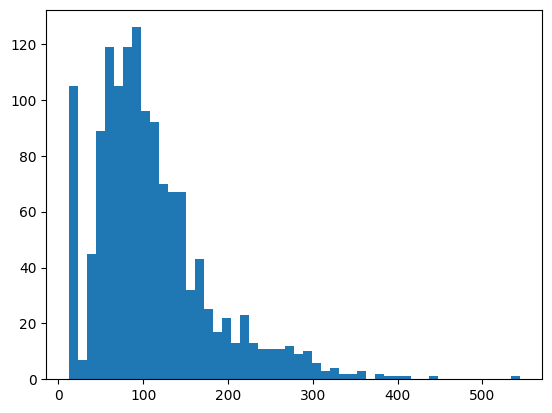

Avg output length:  1649.860028860029
Std. Dev input length:  2845.117845489472


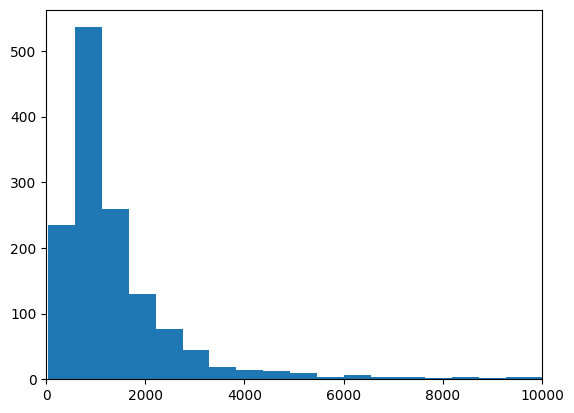

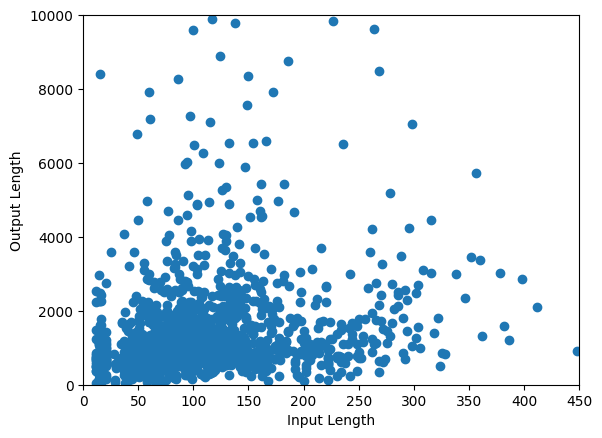

In [ ]:

input_lengths = [len(x["INSTRUCTION"]) for x in val_dataset]
output_lengths = [len(x["RESPONSE"]) for x in val_dataset]
import matplotlib.pyplot as plt
import numpy as np


plt.hist(input_lengths, bins=50)
print("Avg input length: ", np.mean(np.array(input_lengths)))
print("Std. Dev input length: ", np.std(np.array(input_lengths)))
plt.show()

plt.hist(output_lengths, bins=100)
print("Avg output length: ", np.mean(np.array(output_lengths)))
print("Std. Dev input length: ", np.std(np.array(output_lengths)))
plt.xlim(0, 10000)
plt.show()

plt.scatter(input_lengths, output_lengths)
plt.xlabel("Input Length")
plt.ylabel("Output Length")
plt.xlim(0, 450)

plt.ylim(0, 10000)
plt.show()


#Most common phrases in the Input

Shows us that the most common prompts are love, life/death, nature, time. These are potential limitations of what the dataset contains, so perhaps it struggles to generalize beyond that.


In [ ]:
from collections import Counter
import re

def tokenize(text): return re.findall(r'\w+', text.lower())

instr_tokens = []
for instr in val_dataset["INSTRUCTION"]: instr_tokens += (tokenize(instr))
top_tokens = Counter(instr_tokens).most_common(30)

print("Top 30 words in prompts:")
for word, cnt in top_tokens: print(f"{word}: {cnt}")


Top 30 words in prompts:
a: 1659
poem: 1659
about: 1008
living: 757
the: 661
make: 560
write: 551
with: 546
themes: 546
social: 532
commentaries: 532
relationships: 470
nature: 456
love: 395
sciences: 371
arts: 355
life: 319
of: 307
generate: 290
can: 290
you: 290
i: 288
want: 288
activities: 282
following: 273
it: 269
me: 261
compose: 239
death: 193
time: 188


# Report
Write a short report about what you did and why (we mostly want to check you didn't just use chatgpt for the entire thing).

After importing the libraries and loading the dataset, I began experimenting with the peft model training cell. First, I created the peft_config, which sets the parameters of the model. I noticed that the r = 8 corresponds to the # of trainable parameters (basically the “rank” of the peft model), because when I set r = 4, this number halved.

Then, I initially set up the SFTTrainer’s config with the following parameters: max_seq_length=100, per_device_train_batch_size=4, learning_rate=2e-4, num_train_epochs=3, finishing with a training loss of ~1.83 after ~3000 steps.

Trying to improve the training, I tweaked the learning_rate to 1e-4. I hoped that this would enable the model to take more precise steps, since if the lr is too high, the model might overshoot the optimal weights. To compensate for the smaller updates, I doubled the # of epochs to 6. Hoping to improve stability and convergence, I used the Adam optimizer and a linear LR scheduler.

In this notebook, I printed out the iteration where I used 8 epochs. As one can observe, loss plateaus a bit after 6000 steps in the 1.76-1.78 range, which may suggest a limitation of the dataset itself.

Another tweak I wanted to try was setting Gradient accumulation = 4, which essentially scales up the batch size, so that the gradient of the batch would be closer to the true value. However, this would likely require scaling up epochs by 4 (as the model updates less frequently), and that would be quite computationally slow.  

Extra exploration: I wanted to understand the dataset a bit better, so I printed some extra output: the input/output length distributions and the most common phrases in the input.
